In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense

import numpy as np
import pandas as pd
import os
import time

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 2


In [3]:
dataset_url = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
dataset_text = open(dataset_url, 'rb').read().decode(encoding='UTF-8')
print(dataset_text[:1000])

1122304/1115394 [==============================] - 0s 0us/step
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know

In [4]:
vocab = sorted(set(dataset_text))
print(f'There are {len(vocab)} unique characters')

There are 65 unique characters


In [5]:
char2idx = {char:index for index, char in enumerate(vocab)}
char2idx

{'\n': 0,
 ' ': 1,
 '!': 2,
 '$': 3,
 '&': 4,
 "'": 5,
 ',': 6,
 '-': 7,
 '.': 8,
 '3': 9,
 ':': 10,
 ';': 11,
 '?': 12,
 'A': 13,
 'B': 14,
 'C': 15,
 'D': 16,
 'E': 17,
 'F': 18,
 'G': 19,
 'H': 20,
 'I': 21,
 'J': 22,
 'K': 23,
 'L': 24,
 'M': 25,
 'N': 26,
 'O': 27,
 'P': 28,
 'Q': 29,
 'R': 30,
 'S': 31,
 'T': 32,
 'U': 33,
 'V': 34,
 'W': 35,
 'X': 36,
 'Y': 37,
 'Z': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64}

In [6]:
idx2char = np.array(vocab)
idx2char

array(['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
       'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='<U1')

In [7]:
text_as_int = np.array([char2idx[char] for char in dataset_text])
text_as_int[:10]

array([18, 47, 56, 57, 58,  1, 15, 47, 58, 47])

In [8]:
len(dataset_text)

1115394

In [9]:
seq_length = 100
examples_per_epoch = len(dataset_text)//seq_length
examples_per_epoch

11153

In [10]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
for i in char_dataset.take(100):
  print(idx2char[i.numpy()])

F
i
r
s
t
 
C
i
t
i
z
e
n
:


B
e
f
o
r
e
 
w
e
 
p
r
o
c
e
e
d
 
a
n
y
 
f
u
r
t
h
e
r
,
 
h
e
a
r
 
m
e
 
s
p
e
a
k
.




A
l
l
:


S
p
e
a
k
,
 
s
p
e
a
k
.




F
i
r
s
t
 
C
i
t
i
z
e
n
:


Y
o
u


In [11]:
sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

for item in sequences.take(50):
  print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'
'zens, the patricians good.\nWhat authority surfeits on would relieve us: if they\nwould yield us but th'
'e superfluity, while it were\nwholesome, we might guess they relieved us humanely;\nbut they think we a'
're too dear: the leanness that\nafflicts us, the object of our misery, is as an\ninventory to particula'
'rise their abundance; our\nsufferance is a gain to them Let us revenge this with\nour pikes, ere we bec'
'ome rakes: for the gods kn

In [12]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

In [13]:
for input_example, target_example in  dataset.take(1):
  print('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [15]:
vocab_size = 65 # len(vocab)
embedding_dim = 256
rnn_units = 1024

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential()

    model.add(
        Embedding(
            vocab_size,
            embedding_dim,
            batch_input_shape = [batch_size, None]
        )
    )

    model.add(
        GRU(
            rnn_units,
            return_sequences=True,
            stateful=True,
            reset_after=False,
            recurrent_initializer='glorot_uniform'
        )
    )

    model.add(
        Dense(vocab_size)
    )
    
    return model

model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE
)

In [16]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3935232   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,018,497
Trainable params: 4,018,497
Non-trainable params: 0
_________________________________________________________________


In [18]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

array([40,  9, 43, 50, 11, 22, 21, 31, 24, 32, 40, 64,  7,  7, 23, 45, 20,
       10,  7, 18, 36, 19, 59, 15, 19, 58, 64,  0,  4, 10, 31, 36, 63, 41,
       14, 32, 10, 54, 51, 20, 46, 61, 20,  9, 46, 11, 49, 37, 19, 60, 27,
       35, 24,  9, 55, 47, 63,  2,  9, 11, 53, 24, 11, 43,  1, 57,  5,  8,
       56, 60, 11, 32, 25,  8, 43, 35, 35,  0, 43, 18, 46, 48, 56, 47, 27,
       42, 51, 19, 18,  7, 33, 52, 58, 56,  0, 26, 10, 10, 57, 49])

In [19]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 'ts advice.\n\nProvost:\nHe will hear none: he hath evermore had the liberty\nof the prison; give him lea'

Next Char Predictions: 
 "b3el;JISLTbz--KgH:-FXGuCGtz\n&:SXycBT:pmHhwH3h;kYGvOWL3qiy!3;oL;e s'.rv;TM.eWW\neFhjriOdmGF-Untr\nN::sk"


In [20]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [21]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [22]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [23]:
model.compile(
    optimizer='adam',
    loss=loss
)

In [24]:
EPOCHS = 100
history = model.fit(dataset, epochs=EPOCHS, callbacks = [checkpoint_callback])

Epoch 1/100
172/172 [==============================] - 28s 149ms/step - loss: 3.2528
Epoch 2/100
172/172 [==============================] - 27s 149ms/step - loss: 2.0502
Epoch 3/100
172/172 [==============================] - 27s 147ms/step - loss: 1.7519
Epoch 4/100
172/172 [==============================] - 28s 149ms/step - loss: 1.5769
Epoch 5/100
172/172 [==============================] - 27s 150ms/step - loss: 1.4743
Epoch 6/100
172/172 [==============================] - 27s 151ms/step - loss: 1.4070
Epoch 7/100
172/172 [==============================] - 27s 151ms/step - loss: 1.3549
Epoch 8/100
172/172 [==============================] - 27s 150ms/step - loss: 1.3105
Epoch 9/100
172/172 [==============================] - 28s 152ms/step - loss: 1.2702
Epoch 10/100
172/172 [==============================] - 27s 151ms/step - loss: 1.2283
Epoch 11/100
172/172 [==============================] - 27s 150ms/step - loss: 1.1912
Epoch 12/100
172/172 [==============================] - 28s 150

<AxesSubplot:>

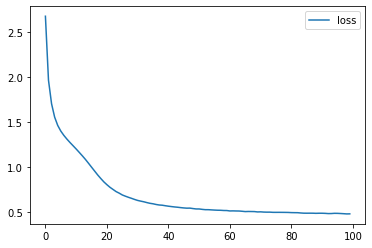

In [25]:
lossPlot = pd.DataFrame(history.history)
lossPlot.plot()

In [26]:
tf.train.latest_checkpoint(checkpoint_dir)

model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3935232   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,018,497
Trainable params: 4,018,497
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.save('model.h5')

In [28]:
model = tf.keras.models.load_model('model.h5')

In [29]:
def generate_text(model, start_string=u'ROMEO:', num_generate=1000, temperature=0.7):
  num_generate = 1000

  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  temperature = 0.1

  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [30]:
print(generate_text(model))

ROMEO:
O, welcome, Oxford! for thee, lords
With all your every name is king: then if I would not--and be gone.

ROMEO:
Give me a torch: I am pale as fill the sky
The shederers of your daughter by your servant.

CAMILLO:
The swifter is an answer.

POLIXENES:
And this we pardon me.

GLOUCESTER:

KING EDWARD IV:
Now tell me, madam, do you love the day.
Brother, we done deeds be not a fliet, though being all too full of wretched by their hates
Of death to my disease; carries and sleep as heaven,
Spuke him to his rudely suffering stuff,
That seest it with the sword of heaven so fierce

PETRUCHIO:
Why, there is time removed by humour with the stars:
There is a slave, whom we have put in prison,
Reports, the Volsces with two several powers
Are specially to be a dishonest person?

LUCIO:
'Cucullus non facit monachum:' honest in nothing
but that I am not Lucentio.

GREMIO:
The Emperor of Russia,
When nights are longest the time and call it not
USTEL:
Now to London, To this sin we begin to us.

